In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

About the dataset:
- handwriten values 0-9
- Each number represents a different categories, therefore multiclass clasification

Image info:
- 28x28 pixels
- 256 different sahdes (0 = white, 255 = black)

Transform:
- Variable used to convert images into a tensor, needed for our model.

Transforms into: 
- Pixel values from 0 to 1.
- Neural networks work better with values from 0 to 1.
- This is also called "normalizing" the data.
- Dataset is already in grayscale, so no need to transfrom to grayscale. 

In [115]:
transform = transforms.ToTensor()

We obtain our train and test data from the vision torch library

In [116]:
#train data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [117]:
#test data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [118]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [119]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataloader: 
- Part of pytorch
- We have to load our dataset into memory
- Instead of doing it all at once, we load it in batches (more manageble)
-Additionally, it automatically & randomly shuffles data (for better learning)

Why?
- To ensure you don't run out of memory
- Batches is better for you cpu/gpu


In [120]:
#load you data in varibales using Pytorch

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

#no need to shuffle test loader
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

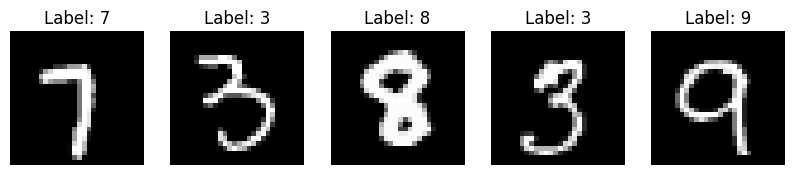

In [121]:
#get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#create a grid of images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):  # display 5 images
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # squeeze to remove extra dimensions
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')  # hide axes for clarity
plt.show()


Lets send just a few images. We'll do this manually (no model):

CNN Model:
- I will attempt to describe a convolutional layer and what its doing
- we will do 2 layers

nn.Conv2d(input size, num of outputs/layers, kernel Size (3x3), stride, padding (not used/how many pixels around our object (written numbers) are dropped))

In [122]:
conv1 = nn.Conv2d(1,6, 3, 1)
conv2 = nn.Conv2d(6,16, 3, 1)
#we picked random output values (6 & 16)

In [123]:
#grab 1 MNIST record/image

#at this moment, train data is just a 28x28 array
for i, (Z_train, W_train) in enumerate(train_data):
    break

#enumarete return a tuple.
#we save the feature into X_train
#and the label/target into y_train

Z_train.shape #size of one image, 28x28

torch.Size([1, 28, 28])

It is not yet a tensor, so we change it from a 2d array into a 4d one (a tensor)

In [124]:
x = Z_train.view(1,1,28,28)

Perform first convulution:

In [125]:
x = F.relu(conv1(x))
#we use relu activation function because it is recommended for nn and cnn

x.shape

#layer has been run
#1 is the one single image
#6 is the outputs we asked for (filters/feature maps)
#26 is now the image. this is the padding taking effect
#the image is now 26x26 as it automatically dropped the "outer pixels"
#out our image as there is nothing there 
#this works even though we did'nt set the padding because of the special images we have,
#which dont have anything in the outer edges
#you need to consider this in real life applications

torch.Size([1, 6, 26, 26])

Pass through a pooling layer:

In [126]:
#kernal of 2, stride of 2
x = F.max_pool2d(x, 2,2)

x.shape

#26 divided by 2 = 13
#we are essentially downsampling the image while retaining important features


torch.Size([1, 6, 13, 13])

Perform second convulution!

In [127]:
x = F.relu(conv2(x))

x.shape

torch.Size([1, 16, 11, 11])

In [128]:
x = F.max_pool2d(x,2,2)
x.shape
#11/2 = 5.5, but we round down because you would be creating data if rounded up

torch.Size([1, 16, 5, 5])

We got an idea of how it works, time to create the model 

In [129]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)

        #fully connected layer for the end
        #flatten it out to 120 (arbitrary)
        #this layer takes the flattened 5x5x16 feature map and flattens it 
        #into a vector of size 5*5*16 = 400 and maps it to 120 neurons
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        #output ends in 10 because we have 10 different nums
        # 0 - 9 

    #capital X, different from demonstration above
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        #second pass/iteration
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        #review data to flatten it out
        X = X.reshape(-1, 16*5*5)
        #-1 so that we can vary the batch size
        #-1 means automatic calculation of the batch size

        #fully conected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        #used softmax because multiclass classification
        #used log softmax instead of softmax because criterion = nn.CrossEntropyLoss()
        



In [130]:
#create an instance
torch.manual_seed(42)
the_Model = CNN()

the_Model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [131]:
#optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(the_Model.parameters(), lr=0.001)
#smaller the learning rate, the slower it is

Traing and Testing begins:

In [132]:
import time
start_time = time.time()

#create variables to keep track of things
epochs = 5 #how many times we go though the whole dataset

train_loss = [] #store training loss values for each epoch
test_loss = [] #   "   testing loss values   "   "     "

#for loop for epochsss
for i in range(epochs):

    train_loss_epoch = 0 #accumulate the training loss for the current epoch
    test_loss_epoch = 0  #     "      "  test loss      "   "     "     "
    
    #these are for our confusion matrix
    train_preds = []  # list to store all predicted labels for training data
    train_labels = [] #  "    "    "    "   true       "     "    "       "
    test_preds = []   # list to store all predicted labels for test data
    test_labels = []  #  "    "    "    "   true      "     "    "    "

    
    #TRAIN:

    #for loop for 10 images (because we made the batch_size = 10)
    for (X_train, y_train) in train_loader:

        #we pass the current image throughout model
        y_pred = the_Model(X_train) 
        #get predicted values from trainig set
        #not flattened, its 2d


        loss = criterion(y_pred, y_train) 
        train_loss_epoch += loss.item()   #.item() is needed as
                                          #loss is a tensor
                                          #gets converted to a float

        #add up the num of corrct predictions

        #torch.max() is used to find the class with the highest score 
        #for each input in the batch. The second argument (1) indicates 
        #that we are taking the maximum along the second dimension (the class predictions)
        #The [1] extracts the indices of the predicted classes.

        predicted = torch.max(y_pred.data, 1)[1]

        #store predictions and true labels:
        train_preds.extend(predicted.numpy())  
        train_labels.extend(y_train.numpy()) 
        #convert to numpy because confusion matrix dont work with tensors  
        
        #update parameters
        #this is the step that adjusts your weights and biases.
        #you calculate the loss for this reason. to send it back and keep moving
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #get the average loss for this epoch
    avg_train_loss = train_loss_epoch / len(train_loader)       
    train_loss.append(avg_train_loss)

    #TEST:

    #no gradient so we dont update weightsd and biases since were just testing
    #with torch.no_grad(): takes care of that^
    with torch.no_grad():
        for (X_test, y_test) in test_loader:
            y_val = the_Model(X_test)
            loss = criterion(y_val, y_test)
            test_loss_epoch += loss.item()

            predicted = torch.max(y_val.data, 1)[1]#adding up correct predictions

            test_preds.extend(predicted.numpy())
            test_labels.extend(y_test.numpy())

    
    avg_test_loss = test_loss_epoch / len(test_loader)
    test_loss.append(avg_test_loss)

    print(f"Epoch {i+1}/{epochs} - Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")


current_time = time.time()
total = current_time - start_time
print(f"this took {total} seconds \n")

print("yay")


Epoch 1/5 - Training Loss: 0.1815196187768403, Test Loss: 0.07457684629404684
Epoch 2/5 - Training Loss: 0.06648662467641467, Test Loss: 0.05403372104704249
Epoch 3/5 - Training Loss: 0.04860418327220524, Test Loss: 0.048808716243392156
Epoch 4/5 - Training Loss: 0.03762455386844557, Test Loss: 0.040436168283644915
Epoch 5/5 - Training Loss: 0.03183516991361855, Test Loss: 0.03632742808718277
this took 34.0609450340271 seconds 

yay


Graph stuff

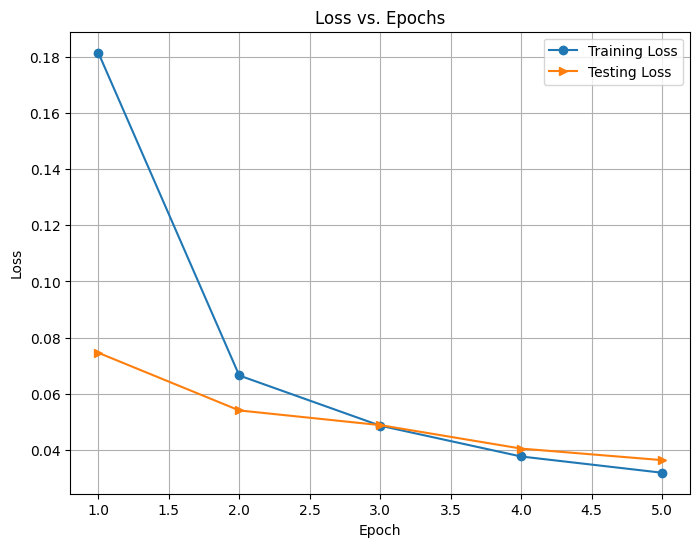

In [133]:
plt.figure(figsize=(8,epochs+1))
plt.plot(range(1, epochs+1), train_loss, label="Training Loss", marker="o")
plt.plot(range(1, epochs+1), test_loss, label="Testing Loss", marker=">")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

In [134]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = the_Model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

#check correctness
print(f"{correct.item()/len(test_data)*100}%")

98.99%


Confusion Matrix:

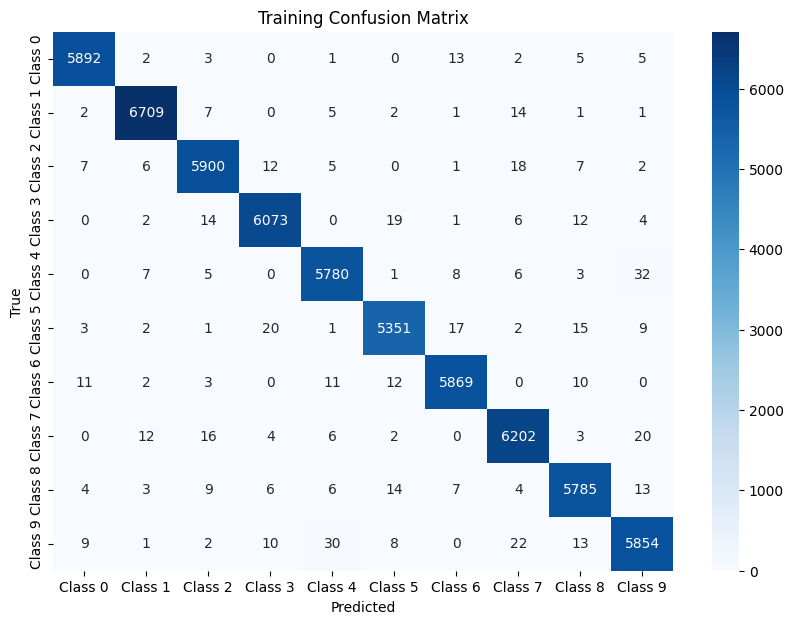

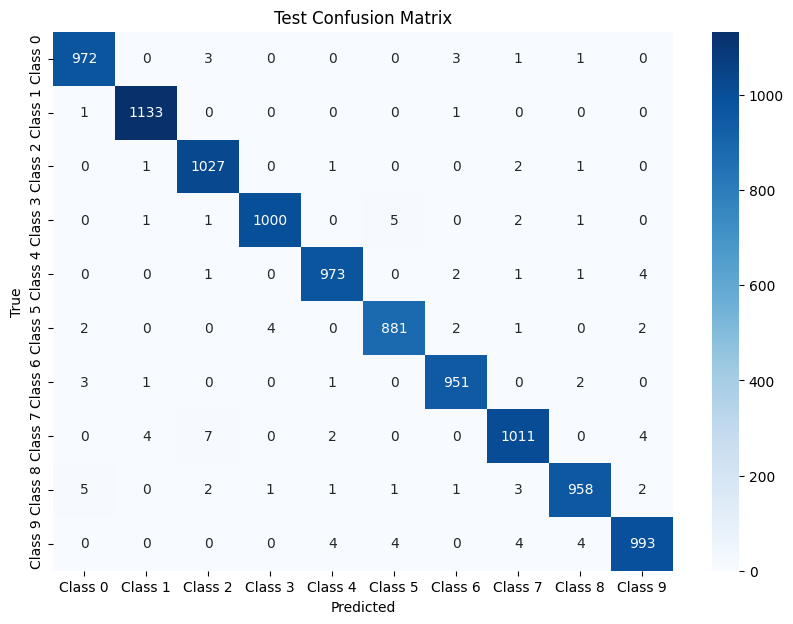

In [135]:
#train confusion matrix
train_cm = confusion_matrix(train_labels, train_preds)
#test confusion matrix
test_cm = confusion_matrix(test_labels, test_preds)

#confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'])
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#test confusion matrix 
plt.figure(figsize=(10,7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [136]:
#tensor with an image in it
#has a label at the very end
test_data[4242]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [137]:
#grab the data and not the label:
test_data[4242][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [138]:
#reshape it
test_data[4242][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

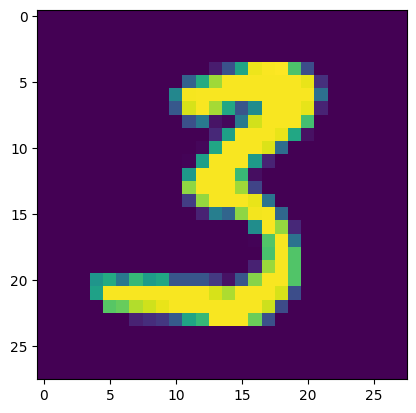

In [139]:
#show it
plt.imshow(test_data[4242][0].reshape(28,28))

In [140]:
#evaluate the image using the model
the_Model.eval()

with torch.no_grad():
    new_prediction = the_Model(test_data[4242][0].view(1,1,28,28)) 
   #batch sie 1, 1 color channel, 2828imagw

In [141]:
new_prediction.argmax()

tensor(3)